# Analyze A/B Test Results 

The Project is organized into the following sections: 

- [Introduction](#intro)
- [Part I - Exploring & Probabilities](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Conclusion](#finalConclusion)

 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.




<a id='probability'></a>
## Part I - Exploring & Probabilities



In [1]:
# Import and reading libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

# Setting the seed 
random.seed(42)

# Start tracking running time
start = dt.datetime.now()

### Description of dataset parameters



|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|

In [2]:
# Reading the data file
df = pd.read_csv('../input/analyze-ab-test-results-notebook/ab_data.csv')

In [3]:
# Reading first few raws of the file
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# identify the shape of the file (raws, columns) count
df.shape 

(294478, 5)

In [5]:
# number of unique users in the dataset 
print('There is a total of', df.nunique()[0], 'unique users in the dataset, out of', df.shape[0], 'transcations recorded')
print('Total users with more than one transcation is ', (df.user_id.value_counts() > 1).sum())

There is a total of 290584 unique users in the dataset, out of 294478 transcations recorded
Total users with more than one transcation is  3894


In [6]:
# Proportion of conversion in the dataset
print(f'Mean conversion: {df.converted.mean():.4f}')

Mean conversion: 0.1197


In [7]:
# Proportion of unique users converted 
users_converted = df.query('converted == 1').user_id.nunique() / df.user_id.nunique()
print(f'Proportion of unique users converted: {users_converted:.4f}')

Proportion of unique users converted: 0.1210


In [8]:
# Number of times when the "group" is treatment but "landing_page" is not a new_page.
treatment_newpage = df.query('group == "treatment" & landing_page != "new_page"')
print(f'Number of times when the "group" is treatment but "landing_page" is not a new_page is {treatment_newpage.shape[0]}')

# Number of times when the "group" is control but "landing_page" is new_page.
control_oldpage = df.query('group != "treatment" & landing_page == "new_page"')
print(f'Number of times when the "group" is control but "landing_page" is new_page is {control_oldpage.shape[0]}')

Number of times when the "group" is treatment but "landing_page" is not a new_page is 1965
Number of times when the "group" is control but "landing_page" is new_page is 1928


### Data Cleaning for mismatched data
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
inaccurate = df.query('group == "treatment" & landing_page != "new_page" | group != "treatment" & landing_page == "new_page"')
df2 = df.drop(inaccurate.index, axis=0)

In [10]:
# Double Check all of the incorrect rows were removed from df2 - 
df2.query('group == "treatment" & landing_page != "new_page" | group != "treatment" & landing_page == "new_page"').shape[0]

0

In [11]:
# Checking for Null values
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [12]:
# How many unique user_ids are in the dataset?
df2.user_id.nunique(), df2.shape[0]

(290584, 290585)

>**There is one `user_id` repeated in the dataset.  What is it?**

In [13]:
# Find duplicate user_id
df2[df2.duplicated(subset='user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
# Duplicated records
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [15]:
# Remove one of the rows with a duplicate user_id..
df2.drop(2893, inplace=True)

# Double check if the row with a duplicate user_id is deleted or not
df2[df2.duplicated(subset='user_id')].shape[0]

0

In [16]:
# What is the probability of an individual converting regardless of the page they receive?
p_population = df2.query('converted == 1').user_id.nunique() / df2.user_id.nunique()
p_population

0.11959708724499628

In [17]:
# What is the probability of an individual converting given he is in the control group?
conversion_control = df2.query('group == "control"').converted.mean()
conversion_control

0.1203863045004612

In [18]:
# What is the probability of an individual converting given he is in the treatment group?
conversion_treatment = df2.query('group != "control"').converted.mean()
conversion_treatment

0.11880806551510564

In [19]:
# What is the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = conversion_control - conversion_treatment
obs_diff

0.0015782389853555567

In [20]:
# What is the probability that an individual received the new page?
df2.query('landing_page == "new_page"').user_id.nunique() / df2.user_id.nunique()

0.5000619442226688

### Observation:
   >1. The probability of an individual received the new page or old page is almost 50%
   >2. The conversion rate for the control group(old page) is slightly higher than the conversion rate for the treatment group
   
**We suspect that the new page is not leading to more conversion**


<a id='ab_test'></a>
## Part II - A/B Test
 

Since just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page, we will assume that the old page is better unless the new page proves to be definitely better at alpha (Type I error rate): 5%
<br><br>
**Hypothesis Test:**
><center>
$H_{0}: $   $p_{old}$ > $p_{new}$ <br><br>
$H_{1}: $   $p_{old}$ $\leq$ $p_{new}$
</center>

In [21]:
# simualting conversion rate on all dataset - Assuming null hypothesis p-new == p-population
new_sample_null = np.random.choice(df2['converted'], df2.shape[0])
new_sample_null.mean()

0.12015458524901577

In [22]:
# simualting conversion rate on all dataset - Assuming null hypothesis p-old == p-population
old_sample_null = np.random.choice(df2['converted'], df2.shape[0])
old_sample_null.mean()

0.12054689865925171

>Considering that the treatment group users are shown the new page, and the control group are shown the old page, **What is number of individuals in each group?**

In [23]:
# number of individuals per group 
individuals_group = df2.groupby('landing_page')['user_id'].nunique()

# number of individuals in treatment group 
individuals_new = individuals_group[0]
print(f'Number of individuals in the treatment group is {individuals_new}')

# number of individuals in control group 
individuals_old = individuals_group[1]
print(f'Number of individuals in the control group is {individuals_old}')

Number of individuals in the treatment group is 145310
Number of individuals in the control group is 145274


In [24]:
# Simulate a sample for the treatment Group, and calculatig conversion rate
new_page_converted = np.random.choice(df2['converted'], individuals_new)
new_page_converted.mean()

0.11950313123666643

In [25]:
# Simulate a sample for the control Group, and calculatig conversion rate
old_page_converted = np.random.choice(df2['converted'], individuals_old)
old_page_converted.mean()

0.12015914754188636

In [26]:
# Simualted difference in conversion rate between new page and old page
converted_diff = new_page_converted.mean() - old_page_converted.mean()
converted_diff

-0.000656016305219928

#### Sampling 10,000 distributions using numpy built-in fuctions

CPU times: user 75.9 ms, sys: 9.16 ms, total: 85.1 ms
Wall time: 80 ms


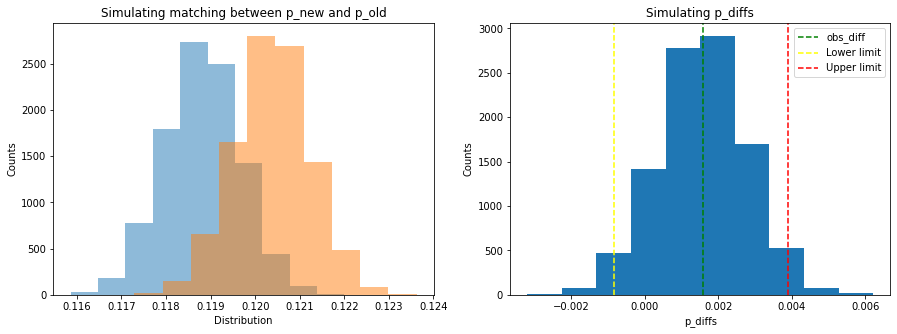

In [27]:
%%time

#Sampling distribution using numpy built-in fuctions

p_new = np.random.binomial(individuals_new, p=conversion_treatment, size=10000) / individuals_new
p_old = np.random.binomial(individuals_old, p=conversion_control, size=10000) / individuals_old
p_diffs = p_old - p_new 

# Visualizing the sampling distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5]);
ax1.hist(p_new, alpha =0.5);
ax1.hist(p_old, alpha =0.5);

ax1.title.set_text('Simulating matching between p_new and p_old');
ax1.set_xlabel('Distribution');
ax1.set_ylabel('Counts');

ax2.hist(p_diffs);
ax2.axvline(obs_diff, color='g', label='obs_diff', ls='--');
ax2.axvline(np.percentile(p_diffs, 2.5), label='Lower limit', c='yellow', ls='--');
ax2.axvline(np.percentile(p_diffs, 97.5), label='Upper limit', c='red', ls='--');
ax2.title.set_text('Simulating p_diffs');
ax2.set_xlabel('p_diffs');
ax2.set_ylabel('Counts');

plt.legend();

In [28]:
#proportion of the p_diffs are greater than the actual difference observed in the df2
probability_diffs = (p_diffs > obs_diff).sum() / 10000
probability_diffs

0.4994

#### Sampling 10,000 distributions using for loops

In [29]:
%%time

#Sampling distribution using for loops
p_diffs = []
p_news = []
p_olds = []

for i in range(10000):
    p_new = np.random.choice(df2['converted'], individuals_new)
    p_news.append(p_new.mean())
    p_old = np.random.choice(df2['converted'], individuals_old)
    p_olds.append(p_old.mean())
    p_diff = p_new.mean() - p_old.mean()
    p_diffs.append(p_diff)

CPU times: user 1min 23s, sys: 19.1 ms, total: 1min 23s
Wall time: 1min 23s


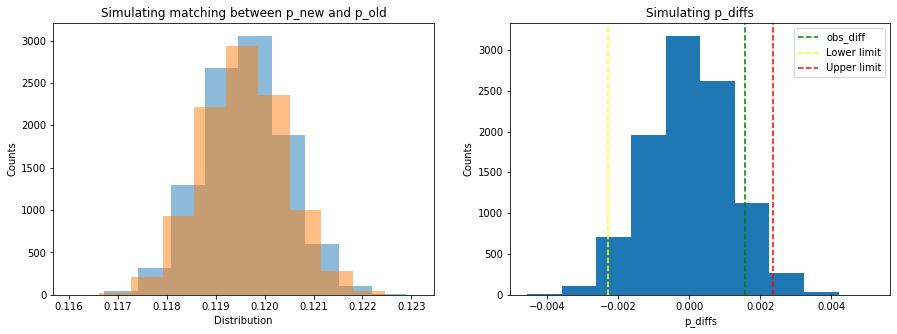

In [30]:
# Visualizing the sampling distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.hist(p_news, alpha =0.5);
ax1.hist(p_olds, alpha =0.5);

ax1.title.set_text('Simulating matching between p_new and p_old');
ax1.set_xlabel('Distribution');
ax1.set_ylabel('Counts');


ax2.hist(p_diffs);
ax2.axvline(obs_diff, color='g', label='obs_diff', ls='--');
ax2.axvline(np.percentile(p_diffs, 2.5), label='Lower limit', c='yellow', ls='--');
ax2.axvline(np.percentile(p_diffs, 97.5), label='Upper limit', c='red', ls='--');

ax2.title.set_text('Simulating p_diffs');
ax2.set_xlabel('p_diffs');
ax2.set_ylabel('Counts');

plt.legend();

In [31]:
#proportion of the p_diffs are greater than the actual difference observed in the df2
probability_diffs = (np.array(p_diffs) > obs_diff).sum() / 10000
probability_diffs

0.0966

**Hypothesis test result** <br>
>1. The P-value of for difference in mean between old and new page using Numpy built-in functions is greater than the Alpha value
>2. The P-value of for difference in mean between old and new page using for loops is also greater than the Alpha value

Since the P-value in both cases is greater than the alpha of 0.05, **we can reject the null hypothesis**

#### Using Stats model - Ztest for Hypothesis Testing

In [32]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page"')['converted'].sum()

# number of conversions with the new_page
convert_new =df2.query('landing_page != "old_page"')['converted'].sum()

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()

# number of individuals who received new_page
n_new = df2.query('landing_page != "old_page"')['user_id'].nunique()

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

In [33]:
# applying sm.stats.proportions_ztest() method 
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'larger')
print(z_score, p_value)

1.3109241984234394 0.09494168724097551


**Hypothesis test result - Z-test** <br> 

>As the observed p value from the z test is higher than the test alpha value of 0.05, we reject the null hypothesis

<a id='regression'></a>
### Part III - A regression approach


We can use **statsmodels** library to fit the regression model to see if there is a significant difference in conversion based on the page-type a customer receives

In [34]:
# Adding an intercept
df2['intercept'] = 1

# Transform group column to using get_dummies and drop control column
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

In [35]:
# Instantiate and fitting the regression model (statsmodels) on the two columns
log = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = log.fit()

# Summary statistics of model
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-10-12 16:55 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**Hypothesis test result - Regression** <br> 

>The p-value of ab_page is 0.1899 which indicates that the variable is not significant in predicating conversion at an alpha rate of 0.05, so we reject the null hypothesis

### Adding countries
In an effort to refine the model performance and trying to get a better assesment to our statistical test, we will add more factors to the regression model to making a better predeication as we are increasing the training data by merging the countries file and adding the effect based on which country a user lives in



In [36]:
# Read the countries file
countries = pd.read_csv('../input/countries/countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
# Join with the df2 dataframe
df_merged = df2.merge(countries, on='user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [38]:
# Create the necessary dummy variables
df_merged[['UK', 'US']] = pd.get_dummies(df_merged['country']).drop('CA', axis=1)

In [39]:
# Create new variables to check interaction between page and country
df_merged['ab_UK'] = df_merged['ab_page'] * df_merged['UK']
df_merged['ab_US'] = df_merged['ab_page'] * df_merged['US']
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,ab_UK,ab_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1,0,0


In [40]:
# Instantiate, fitting the model and summarizing the results
log2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page','UK', 'US', 'ab_UK', 'ab_US']])
result2 = log2.fit()
result2.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-10-12 16:55 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
ab_UK          0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
ab_US          0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

<a id='finalConclusion'></a>
# Final conclusions<br> 
>  **<center>The p-values are above the alpha value of 0.05, we reject the null hypothesis</center>**  
>- Considering the facts stated from all the previous statistical tests we can denote the below:<br><br>
    1. There is no apparent statistical difference in performance between old page and the new page in terms of conversions rate, even with taking the the location of the customer in consideration<br><br>
    2. Deciding on whether to continue with the new page or the old one is not yet conclusive, if we look at the subject from a practical perspective will require including other features about the customers and the products, also cost is a huge contributor in the decision making process

In [41]:
finish = dt.datetime.now()
duration =  finish - start
print(f'Total running time is {str(duration)[2:4]} minute, {str(duration)[5:7]} seconds')

Total running time is 01 minute, 37 seconds
